## Installation - Loading the Gymnasium custom environment: LifeSim

Since we're using a custom environment, we need to install its package into the pip environment, such that it will be usable from the gymnasium library. The following code is based on a Google Colab's run.

In [1]:
'''
# %%capture
#!rm -rf /content/gym_projects
!unzip - o / content/archive.zip
!pip uninstall - -no-input life-sim
!pip install - -no-input - e / content/gym_projects/
'''

'\n# %%capture\n#!rm -rf /content/gym_projects\n!unzip - o / content/archive.zip\n!pip uninstall - -no-input life-sim\n!pip install - -no-input - e / content/gym_projects/\n'

If the environment cannot be made with gymnasium.make(), it may be useful to restart the runtime.

In [2]:
'''
import os

def restart_runtime():
  os.kill(os.getpid(), 9)

restart_runtime()
'''


'\nimport os\n\ndef restart_runtime():\n  os.kill(os.getpid(), 9)\n\nrestart_runtime()\n'

## Creating the environment

In [3]:
import gymnasium as gym
import gymnasium.vector
import numpy as np
#import tensorflow as tf
#from tensorflow import keras
#from keras import initializers
from collections import deque
import random
from life_sim.envs import LifeSim, LifeSteps
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from agent import DQN_Agent, Agent, PPO_Agent
import agent
#from tensorflow import GradientTape
import memory
import tensorflow as tf
import importlib
importlib.reload(gym)
importlib.reload(memory)
importlib.reload(agent)

# Load the TensorBoard notebook extension
#%load_ext tensorboard
import datetime
log_dir = "logs/scalars/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
#summary_writer = tf.summary.create_file_writer(log_dir)
# Clear any logs from previous runs
#%rm -rf ./logs/

2023-06-25 17:56:47.879281: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-25 17:56:48.631856: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Set seeds for reproducibility.

In [4]:
seed = 101
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [5]:

#tf.debugging.set_log_device_placement(True)
'''
physical_devices = tf.config.list_physical_devices('GPU')
try:
  tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
  # Invalid device or cannot modify virtual devices once initialized.
  pass
'''

"\nphysical_devices = tf.config.list_physical_devices('GPU')\ntry:\n  tf.config.experimental.set_memory_growth(physical_devices[0], True)\nexcept:\n  # Invalid device or cannot modify virtual devices once initialized.\n  pass\n"

Adding some useful settings and dictionaries to ease the code

In [6]:
# numpy settings for printing the states, if needed
np.set_printoptions(precision=4)

# some useful dictionaries used to let the code be more readable
# and less error-prone
num_actions = 3

actions = {
    "work": 0,
    "sport": 1,
    "sociality": 2
}

actions_array = {
    0: np.transpose([1, 0, 0]),
    1: np.transpose([0, 1, 0]),
    2: np.transpose([0, 0, 1]),
}

state_map = {
    "money": 0,
    "health": 1,
    "work development": 2,
    "social development": 3,
}

### Utils

Here we code some useful functions to visualize the results of the training and evaluate the model performance on the environment.

In [7]:
def plot_results(observations, rewards):
    # Plotting the first set of data
    performances = np.transpose(observations)
    plt.figure(1)
    plt.plot(performances[state_map['money']], label='Money')
    plt.plot(performances[state_map['health']], label='Health')
    plt.plot(performances[state_map['work development']],
             label='Work Development')
    plt.plot(performances[state_map['social development']],
             label='Social Development')
    plt.xlabel('Time')
    plt.ylabel('Values')
    plt.title('State plot')
    plt.legend()

    # Plotting the second set of data
    plt.figure(2)
    plt.plot(rewards, label='Reward')
    plt.xlabel('Time')
    plt.ylabel('Values')
    plt.title('Rewards plot')
    plt.legend()

    # Plotting the second set of data
    plt.figure(3)
    plt.plot(np.cumsum(rewards), label='Cumulative Reward')
    plt.xlabel('Time')
    plt.ylabel('Values')
    plt.title('Cumulative reward plot')
    plt.legend()

    # Displaying the plots
    plt.show()


In [8]:
def training_results(rewards, actions, normalize=False):
    # Normalize the data
    actions = np.transpose(actions)

    if normalize:
        f = np.max(rewards)
        rewards = [r/f for r in rewards]
        f = np.max([np.max(actions[i]) for i in range(len(actions))])
        actions = [[a/f for a in actions[i]] for i in range(len(actions))]

    # Plotting the first set of data
    plt.figure(1)
    plt.plot(actions[0], label='Work')
    plt.plot(actions[1], label='Sport')
    plt.plot(actions[2], label='Sociality')
    plt.xlabel('Training Steps')
    plt.ylabel('Values')
    plt.xticks(np.arange(0, len(actions[0]), 1))
    plt.title('# of Actions, per training step')
    plt.legend()

    # Plotting the second set of data
    plt.figure(2)
    plt.plot(rewards, label='Cumulative Reward')
    plt.xlabel('Training Steps')
    plt.ylabel('Values')
    plt.xticks(np.arange(0, len(rewards), 1))
    plt.title('Cumulative Rewards plot, per training step')
    plt.legend()

    # Displaying the plots
    plt.show()


In [9]:
def plot_losses(actor_loss, critic_loss, logscale = False, reduce_n=None):

    if reduce_n is not None:
        actor_loss = np.array(actor_loss).reshape(-1, reduce_n).mean(axis=1)
        critic_loss = np.array(critic_loss).reshape(-1, reduce_n).mean(axis=1)

    plt.figure(1)
    plt.plot(actor_loss, label='Mean Actor Loss per Update')
    plt.xlabel('Updates')
    plt.xticks(np.arange(1,len(actor_loss),1))
    plt.ylabel('Mean loss')
    if logscale: plt.yscale('log')
    plt.title('Actor Loss Plot')
    plt.legend()

    plt.figure(2)
    plt.plot(critic_loss, label='Mean Critic Loss per Update')
    plt.xlabel('Updates')
    if logscale: plt.yscale('log')
    plt.xticks(np.arange(1,len(critic_loss),1))
    plt.ylabel('Mean loss')
    plt.title('Critic Loss Plot')
    plt.legend()

    # Displaying the plots
    plt.show()


### Training the Agent

In [10]:
def training_step(agent: Agent, batch_size):

    loss = agent.train(replay_buffer, batch_size)
    return loss


def add_cumulative_reward(cumulative_rewards, avg_sum_reward, sum_rewards, tau):

    avg_sum_reward = (avg_sum_reward*(tau - 1) + sum_rewards)/tau
    cumulative_rewards.append(avg_sum_reward)


def add_sum_action(sum_actions, avg_sum_actions, actions, tau):

    avg_sum_actions = (np.dot(avg_sum_actions, (tau - 1)) + actions)/tau
    sum_actions.append(avg_sum_actions)


def calc_epsilon(episode, n_episodes, decay):
    return max(1 - episode/(n_episodes*decay), 0.05)


In [11]:
def play_one_step(vec_env, v_actions, epsilon):

    next_states, rewards, terminateds, truncateds, infos = vec_env.step(v_actions)
    return next_states, rewards, terminateds, truncateds, infos, v_actions


In [12]:
def play_episodes(n_episodes, tau):
    # cumulative rewards averaged over tau episodes
    cumulative_rewards = []
    sum_actions = []

    avg_sum_reward = 0
    avg_sum_actions = np.transpose([0, 0, 0])

    for episode in tqdm(np.arange(1, n_episodes, 1), desc="Episodes", position=0):

        sum_rewards = 0
        actions = np.transpose([0, 0, 0])

        v_obs, v_info = vec_env.reset()

        for step in np.arange(1, max_steps, 1):

            epsilon = calc_epsilon(episode, n_episodes=n_episodes, decay=0.8)

            actions = [dqn_agent.predict(o, 0.5) for o in obs]

            v_new_obs, v_reward, v_terminated, v_truncated, v_info, v_action = play_one_step(
                vec_env, actions, epsilon)
            [replay_buffer.append((v_obs[i], v_action[i], v_reward[i],
                                  v_new_obs[i], v_terminated[i])) for i in range(len(obs))]

            sum_rewards = sum_rewards + np.sum(v_reward)
            actions = actions + actions_array[v_info['last_action']]

            []
            # env.render()
            # if terminated or truncated:
            #    break

        if episode % tau == 0:

            add_cumulative_reward(cumulative_rewards,
                                  avg_sum_reward, sum_rewards, tau)
            add_sum_action(sum_actions, avg_sum_actions, actions, tau)
        else:

            avg_sum_reward = (avg_sum_reward*(episode %
                              tau - 1) + sum_rewards)/(episode % tau)
            avg_sum_actions = (
                np.dot(avg_sum_actions, (episode % tau - 1)) + actions)/(episode % tau)

            if episode > 10 and episode % tau == 0:
                training_step(dqn_agent, batch_size)

    return cumulative_rewards, sum_actions


In [13]:
def play_steps(vec_env, max_steps, tau):
    # cumulative rewards averaged over tau episodes
    cumulative_rewards = []
    sum_actions = []

    avg_sum_reward = 0
    avg_sum_actions = np.transpose([0, 0, 0])

    steps = 0

    v_obs, v_info = vec_env.reset(seed=seeds)

    sum_rewards = 0
    actions = np.transpose([0, 0, 0])


    for steps in tqdm(np.arange(1, max_steps, 1), desc="Steps", position=0):

        epsilon = calc_epsilon(steps, max_steps, decay=0.8)
        v_actions = np.array([dqn_agent.predict(o, 0) for o in v_obs])
        #v_new_obs, v_reward, v_terminated, v_truncated, v_info, v_action = play_one_step(vec_env, v_actions, epsilon)
        v_new_obs, v_reward, v_terminated, v_truncated, v_info, v_action = play_one_step(vec_env, v_actions, epsilon)

        # save in buffer for the resetted envs
        # different code because of the vec_env.step() behaviour in case of truncated or terminated episode
        resetted_envs = [i for i in range(len(v_truncated)) if v_truncated[i] or v_terminated[i]]
        replay_buffer.extend([(v_obs[i], v_action[i], v_reward[i], v_info['final_observation'][i], v_terminated[i]) for i in resetted_envs])

        # save in buffer
        not_resetted_envs = [i for i in range(len(v_truncated)) if not v_truncated[i] and not v_terminated[i]]
        replay_buffer.extend([(v_obs[i], v_action[i], v_reward[i], v_new_obs[i], v_terminated[i]) for i in not_resetted_envs])

        #sum_rewards = sum_rewards + np.sum(v_reward)
        #actions = actions + \
        #    actions_array[np.sum(v_info['last_action'], axis=1)]

        if steps % tau == 0:
            training_step(dqn_agent, batch_size)

    
    return cumulative_rewards, sum_actions


In [14]:
'''
from tensorflow.compat import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.2
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)
'''

'\nfrom tensorflow.compat import ConfigProto\nfrom tensorflow.compat.v1 import InteractiveSession\n\nconfig = ConfigProto()\nconfig.gpu_options.per_process_gpu_memory_fraction = 0.2\nconfig.gpu_options.allow_growth = True\nsession = InteractiveSession(config=config)\n'

In [15]:
# max number of steps for each episode of the simulator.
# if reached, the environment is TRUNCATED by the TimeLimit wrapper
#max_steps = 300
num_envs = 32
t_seeds = [int(x) for x in np.random.randint(1, 100000 + 1, size=1000)]
seeds = t_seeds[:num_envs]
env_max_timesteps = 300

# create the vectorized environment
#vec_env = gymnasium.vector.make(
#    'life_steps/LifeSteps-v0', num_envs=num_envs, asynchronous=True, max_timesteps=env_max_timesteps)
vec_env = gymnasium.vector.make(
    'CartPole-v1', num_envs=num_envs, asynchronous=True)


In [16]:
input_shape = [vec_env.single_observation_space.shape[0]]
#input_shape = [vec_env.single_observation_space.shape[0]]
n_outputs = vec_env.single_action_space.n
n_outputs

2

In [17]:
num_steps = 15000
# discount
gamma = 0.80
# lambda is the GAE parameter
lmbda = 0.95
# clipping parameter
epsilon = 0.2
# entropy parameter
c2 = 0.03
batch_timesteps = 128
minibatch_size = 32
epochs = 4

lr_actor = 2.5e-4
lr_critic = 2.5e-4

In [18]:
#ppo_critic_optimizer = keras.optimizers.AdamW(learning_rate=lr)
#ppo_actor_optimizer = keras.optimizers.AdamW(learning_rate=lr)

In [19]:
m = memory.Memory(num_envs = num_envs, obs_shape = vec_env.single_observation_space.shape, timesteps = batch_timesteps)

In [20]:
import agent
importlib.reload(agent)
ppo_agent = agent.PPO_Agent(input_shape, 
                            n_outputs, 
                            gamma, 
                            lmbda, 
                            epsilon, 
                            c2, 
                            lr_actor, 
                            lr_critic, 
                            log=True, 
                            log_dir=log_dir, 
                            env_max_timesteps=env_max_timesteps)

2023-06-25 17:56:51.349143: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-25 17:56:51.376936: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-25 17:56:51.377142: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Train the model for the decided time.

In [21]:
#from agent import play_n_timesteps
#mean_losses_actor, mean_losses_critic = ppo_agent.play_n_timesteps(vec_env, m, num_steps, batch_timesteps, minibatch_size, epochs)

# with tensorboard logging
ppo_agent.play_n_timesteps(vec_env, m, num_steps, batch_timesteps, minibatch_size, epochs)

/home/daniel/.local/lib/python3.10/site-packages/gymnasium/envs/registration.py:787: UserWarning: WARN: The environment is being initialised with render_mode='text' that is not in the possible render_modes (['human', 'rgb_array']).
  logger.warn(


  0%|          | 0/117 [00:00<?, ?it/s]

ValueError: could not broadcast input array from shape (128,32) into shape (32,)

In [28]:
next_val = ppo_agent.get_value(vec_env.observation_space.sample()).numpy().squeeze()
delta = m.rewards[127] + gamma*next_val*m.terminateds[127] - m.values[127]

AttributeError: 'Memory' object has no attribute 'termianteds'

In [24]:
d1 = m.rewards[0] + gamma*m.values[1]*m.terminateds[0] - m.values[0]
d2 = m.rewards[1] + gamma*m.values[2]*m.terminateds[1] - m.values[1]
d1 + d2

array([2.0356, 1.9227, 1.9714, 1.9986, 2.0483, 1.9662, 2.0549, 2.0153,
       2.0121, 2.0466, 1.9562, 2.0524, 1.9256, 1.9675, 1.9675, 2.0038,
       2.0626, 2.0569, 1.9816, 1.961 , 1.987 , 1.9387, 1.9892, 2.0011,
       1.9729, 2.0526, 2.0259, 2.0237, 1.9535, 2.0479, 1.9716, 1.9791],
      dtype=float32)

In [25]:
m.advantages[0].shape

(32,)

In [ ]:
ppo_agent.actor(vec_env.observation_space.sample())

<tf.Tensor: shape=(32, 2), dtype=float32, numpy=
array([[0.0000e+00, 1.3400e+38],
       [0.0000e+00,        inf],
       [0.0000e+00,        inf],
       [0.0000e+00,        inf],
       [0.0000e+00, 0.0000e+00],
       [0.0000e+00,        inf],
       [0.0000e+00,        inf],
       [0.0000e+00, 0.0000e+00],
       [0.0000e+00, 0.0000e+00],
       [0.0000e+00,        inf],
       [0.0000e+00, 0.0000e+00],
       [0.0000e+00,        inf],
       [0.0000e+00, 0.0000e+00],
       [0.0000e+00,        inf],
       [0.0000e+00, 0.0000e+00],
       [0.0000e+00,        inf],
       [0.0000e+00,        inf],
       [0.0000e+00, 0.0000e+00],
       [0.0000e+00,        inf],
       [0.0000e+00, 2.3182e+37],
       [0.0000e+00,        inf],
       [0.0000e+00,        inf],
       [0.0000e+00,        inf],
       [0.0000e+00, 1.7325e+37],
       [0.0000e+00, 3.6018e+37],
       [0.0000e+00,        inf],
       [0.0000e+00,        inf],
       [0.0000e+00, 0.0000e+00],
       [0.0000e+00,        

In [22]:
ppo_agent.save_models("first_train")

INFO:tensorflow:Assets written to: models/20230624-001328/actor-first_train_entropic/assets


INFO:tensorflow:Assets written to: models/20230624-001328/actor-first_train_entropic/assets


INFO:tensorflow:Assets written to: models/20230624-001328/critic-first_train_entropic/assets


INFO:tensorflow:Assets written to: models/20230624-001328/critic-first_train_entropic/assets


Evaluating the model for 200 steps.

In [22]:
eval_episodes = 300
eval_seeds = t_seeds[:eval_episodes]
#env = gymnasium.make('life_sim/LifeSim-v0', render_mode='text', max_timesteps=env_max_timesteps)

# with tensorboard logging
ppo_agent.evaluate(eval_episodes, seeds=eval_seeds, eval_code=90)

AttributeError: 'numpy.ndarray' object has no attribute 'numpy'

partial results

mean cumulative rewards: 2.95
updates: 429/1406
num_steps = 180000

--discount
gamma = 0.5

--lambda is the GAE parameter
lmbda = 0.95

--clipping parameter
epsilon = 0.3
--entropy parameter
c2 = 0.005
batch_timesteps = 128
minibatch_size = 32
epochs = 6

lr_actor = 3e-4
lr_critic = 6e-4

In [ ]:
'''
import utils
import numpy as np
truncateds =	[0,0,0,0,0,0,0,0,0,0]
terminateds =	[0,0,0,0,0,0,0,1,0,0]
rewards =	[0,0,0,0,0,0,0,-0.0879,0,0]
next_value = 1
values = np.zeros(shape=(10))
g = 0.9
l = 0.95

ret = utils.calc_returns(9, 0, rewards, g, terminateds, truncateds)
advv = utils.calc_adv_list_wlast(9, 0, rewards, values, g, l, truncateds, terminateds, next_value)
print(ret)
print(advv)
'''

[-0.04204229751000001, -0.04671366390000001, -0.05190407100000001, -0.05767119000000001, -0.06407910000000001, -0.07119900000000001, -0.07911000000000001, -0.0879, 0.0, 0]
[-0.029359704364702397, -0.03433883551427181, -0.040162380718446564, -0.0469735446999375, -0.05493981836250001, -0.06425709750000001, -0.07515450000000001, -0.0879, 0.7695, 0.9]


In [25]:
# max number of steps for each episode of the simulator.
# if reached, the environment is TRUNCATED by the TimeLimit wrapper
#max_steps = 300

# create the vectorized environment
env = gymnasium.make('CartPole-v1', render_mode='human')

cumulative_rewards = []
sum_actions = []

avg_sum_reward = 0
avg_sum_actions = np.transpose([0, 0, 0])

n_episodes = 1
t = 0

for episode in tqdm(np.arange(1, n_episodes+1, 1), desc="Episodes", position=0):

    #print(f"Episode {episode}")
    sum_rewards = 0
#    actions = np.transpose([0, 0, 0])

    obs, info = env.reset(seed=eval_seeds[t])
    t += 1

    #for step in np.arange(1, max_steps, 1):
    while True:    
#        epsilon = calc_epsilon(episode, n_episodes=n_episodes, decay=0.8)

        action = ppo_agent.get_action(obs)

        new_obs, reward, terminated, truncated, info = env.step(action)

#        actions = actions + actions_array[action]

        sum_rewards += reward
#        actions = actions + actions_array[v_info['last_action']]

        #env.render()
        if terminated or truncated:
           break

#    sum_actions.append(actions)
    cumulative_rewards.append(sum_rewards)
    
#training_results(cumulative_rewards, sum_actions)

Episodes:   0%|          | 0/1 [00:00<?, ?it/s]

: 

: 

In [22]:
# max number of steps for each episode of the simulator.
# if reached, the environment is TRUNCATED by the TimeLimit wrapper
#max_steps = 300

# create the vectorized environment
env = gymnasium.make('CartPole-v1', render_mode='human')

cumulative_rewards = []
sum_actions = []

avg_sum_reward = 0
avg_sum_actions = np.transpose([0, 0, 0])

n_episodes = 1
t = 0

for episode in tqdm(np.arange(1, n_episodes+1, 1), desc="Episodes", position=0):

    #print(f"Episode {episode}")
    sum_rewards = 0
    actions = np.transpose([0, 0, 0])

    obs, info = env.reset()
    t += 1

    #for step in np.arange(1, max_steps, 1):
    while True:    
        epsilon = calc_epsilon(episode, n_episodes=n_episodes, decay=0.8)

        action = np.random.randint(3)

        new_obs, reward, terminated, truncated, info = env.step(action)

        actions = actions + actions_array[action]

        sum_rewards += reward
#        actions = actions + actions_array[v_info['last_action']]

        #env.render()
        if terminated or truncated:
           break

    sum_actions.append(actions)
    cumulative_rewards.append(sum_rewards)
    
training_results(cumulative_rewards, sum_actions)

Episodes:   0%|          | 0/1 [00:00<?, ?it/s]

: 

: 

In [ ]:
print(np.mean(cumulative_rewards))

0.09997329235076904


In [ ]:
#plot_losses(mean_losses_actor, mean_losses_critic, logscale = False, reduce_n=None)

In [ ]:
#%tensorboard --logdir log_dir

Evaluating the model for 200 episodes.

In [ ]:
ll = []
for xt in range(128):
    rr = 0
    for i in range(128-xt):
        if m.truncateds[i,0] or m.terminateds[i,0]:
            rr += m.f_rewards[127-i]
            break
        else:
            rr += np.power(gamma, 128-i)*m.f_rewards[127-i]
    ll.append(rr) 

for j in range(len(ll)):
    print(ll[len(ll)-1-j])

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


In [ ]:

# max number of steps for each episode of the simulator.
# if reached, the environment is TRUNCATED by the TimeLimit wrapper
#max_steps = 300

# create the vectorized environment
'''
env = gymnasium.make('life_sim/LifeSim-v0', render_mode='text', max_timesteps=env_max_timesteps)

cumulative_rewards = []
sum_actions = []

avg_sum_reward = 0
avg_sum_actions = np.transpose([0, 0, 0])

n_episodes = 200

for episode in tqdm(np.arange(1, n_episodes+1, 1), desc="Episodes", position=0):

    #print(f"Episode {episode}")
    sum_rewards = 0
    actions = np.transpose([0, 0, 0])

    obs, info = env.reset()

    #for step in np.arange(1, max_steps, 1):
    while True:    

        action, _ , _= ppo_agent.get_action(obs[np.newaxis])

        action = action.numpy().squeeze().tolist()
        new_obs, reward, terminated, truncated, info = env.step(action)

        actions = actions + actions_array[action]

        sum_rewards += reward
#        actions = actions + actions_array[v_info['last_action']]

        #env.render()
        if terminated or truncated:
           break

    sum_actions.append(actions)
    cumulative_rewards.append(sum_rewards)
'''

Episodes:   0%|          | 0/200 [00:00<?, ?it/s]

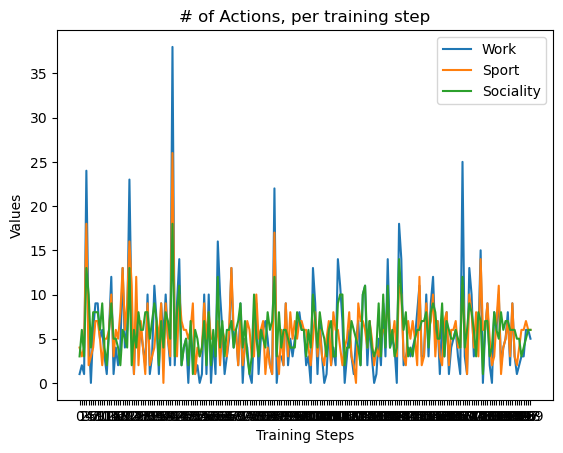

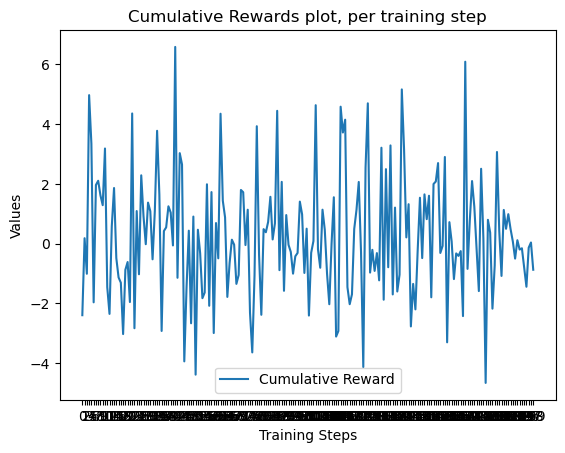

In [ ]:
#training_results(cumulative_rewards, sum_actions)

Let's print the mean of the cumulative rewards obtained in the previous 50 evaluated episodes:

In [ ]:
#print(np.mean(cumulative_rewards))

0.2158199691772461


In [ ]:
# max number of steps for each episode of the simulator.
# if reached, the environment is TRUNCATED by the TimeLimit wrapper
#max_steps = 300

# create the vectorized environment
'''
env = gymnasium.make('life_sim/LifeSim-v0', render_mode='text', max_timesteps=env_max_timesteps)

cumulative_rewards = []
sum_actions = []

avg_sum_reward = 0
avg_sum_actions = np.transpose([0, 0, 0])

n_episodes = 200

for episode in tqdm(np.arange(1, n_episodes+1, 1), desc="Episodes", position=0):

    #print(f"Episode {episode}")
    sum_rewards = 0
    actions = np.transpose([0, 0, 0])

    obs, info = env.reset()

    #for step in np.arange(1, max_steps, 1):
    while True:    
        epsilon = calc_epsilon(episode, n_episodes=n_episodes, decay=0.8)

        action = np.random.randint(3)

        new_obs, reward, terminated, truncated, info = env.step(action)

        actions = actions + actions_array[action]

        sum_rewards += reward
#        actions = actions + actions_array[v_info['last_action']]

        #env.render()
        if terminated or truncated:
           break

    sum_actions.append(actions)
    cumulative_rewards.append(sum_rewards)
    
training_results(cumulative_rewards, sum_actions)
'''

Episodes:   0%|          | 0/200 [00:00<?, ?it/s]

Let's print the mean of the cumulative rewards obtained in the previous 50 evaluated episodes, taking random actions:

In [ ]:
#print(np.mean(cumulative_rewards))

0.15313159227371215


Let's keep training, because the performance are pretty awful.

In [ ]:
num_steps = 200000
# discount
gamma = 0.75
# lambda is the GAE parameter
lmbda = 0.95
# clipping parameter
epsilon = 0.1
# entropy parameter
c2 = 0.05
batch_timesteps = 128
minibatch_size = 32
epochs = batch_timesteps // minibatch_size

lr_actor = 1e-3
lr_critic = 6e-3

ppo_agent.actor.load_weights('actor_network_weights')
ppo_agent.critic.load_weights('critic_network_weights')

In [ ]:
mean_losses_actor, mean_losses_critic = ppo_agent.play_n_timesteps(vec_env, m, num_steps, batch_timesteps, minibatch_size, epochs)

ppo_agent.actor.save_weights('checkpoints/actor/actor_network_weights_2')
ppo_agent.critic.save_weights('checkpoints/critic/critic_network_weights_2')

plot_losses(mean_losses_actor, mean_losses_critic, logscale = False, reduce_n=None)

  0%|          | 0/1562 [00:00<?, ?it/s]

2023-06-18 10:45:13.302969: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at sparse_xent_op.cc:102 : INVALID_ARGUMENT: Received a label value of 3 which is outside the valid range of [0, 3).  Label values: 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3


InvalidArgumentError: {{function_node __wrapped__SparseSoftmaxCrossEntropyWithLogits_device_/job:localhost/replica:0/task:0/device:CPU:0}} Received a label value of 3 which is outside the valid range of [0, 3).  Label values: 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 [Op:SparseSoftmaxCrossEntropyWithLogits]

Here we should start training and testing the DQN

In [ ]:
tau = 100
max_steps = 1585

cumulative_rewards, sum_actions = play_steps(vec_env, max_steps, tau)
training_results(cumulative_rewards, sum_actions, normalize=True)

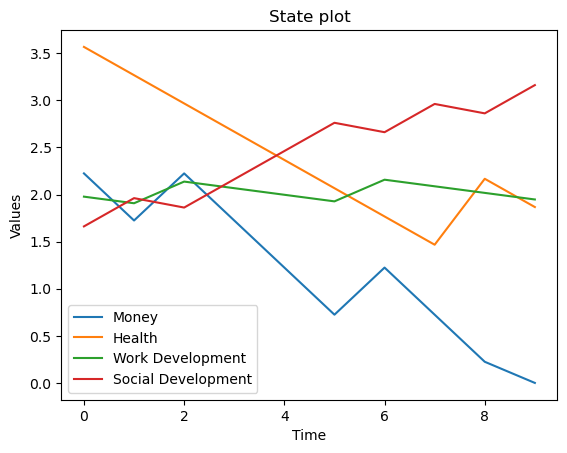

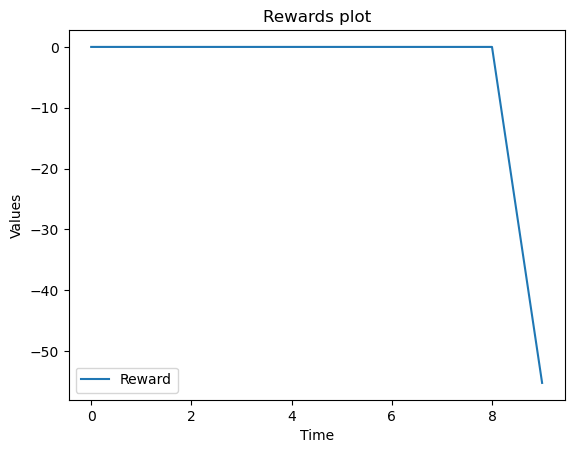

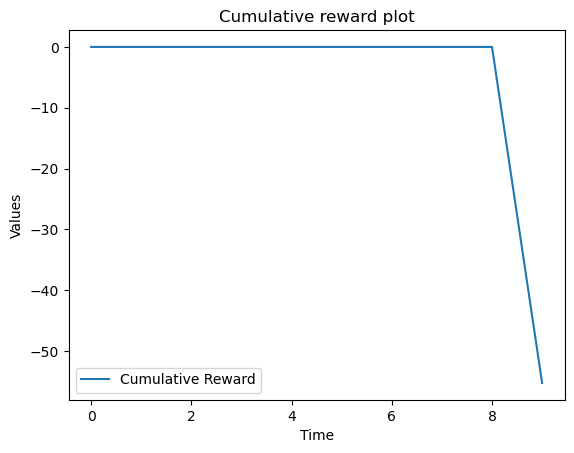

In [ ]:
observations = []
rewards = []

obs, info = env.reset()

done = False
terminated = False
while not done and not terminated:
    obs, reward, terminated, truncated, info = env.step(np.random.randint(3))
    # print(np.array2string(obs))
    observations.append(obs)
    # print(np.array2string(reward))
    rewards.append(reward)
    if terminated or truncated:
        break

plot_results(observations, rewards)


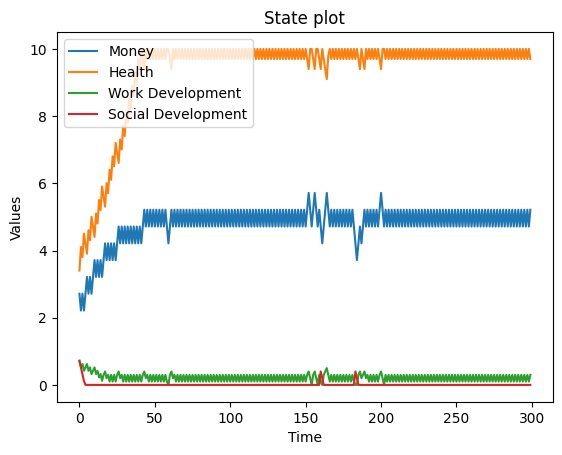

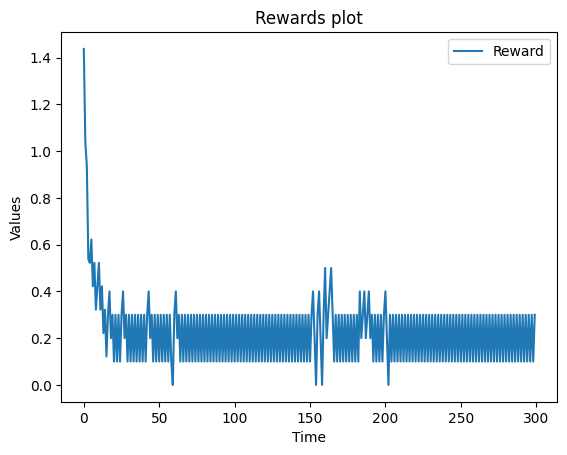

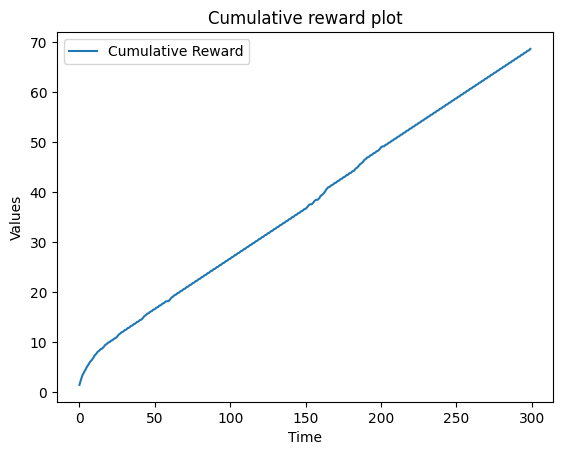

In [ ]:
observations = []
rewards = []

for episode in range(1):

    obs, info = env.reset()
    for step in range(1000):
        epsilon = 0.05
        obs, reward, terminated, truncated, info, action = dqn_agent.play_one_step(
            env, obs, epsilon)
        observations.append(obs)
        rewards.append(reward)
        # env.render()
        if terminated or truncated:
            break

plot_results(observations, rewards)
